# Modeling - First Pass

### Installs, Packages, Seeds

In [1]:
# %pip install efficientnet_pytorch

In [ ]:
%pip install torch
# %pip install torchvision

In [1]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
# from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# other
import importlib

Matplotlib is building the font cache; this may take a moment.


In [2]:
# import build_model
# importlib.reload(build_model)

# from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Parameters

In [3]:
model_dict = {'pretrained_model': 'resnet',
              'epochs': 3,
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/gridsearch',
              'csv_name': 'full_data_rename',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .002,
              'batch_size':64,
              'num_workers':24,
              'transform_set':'a',
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


## Data

In [4]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                         csv_name = model_dict['csv_name'], 
                                         data_split = model_dict['split'], 
                                         label = model_dict['cl'],
                                         mode = 'all',
                                         dev_state = model_dict['dev_state'], 
                                         dev_sample = model_dict['dev_sample'], 
                                         seed = model_dict['seed']
                                         )

## Modeling

In [5]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                        num_classes = len(data.label.unique()),
                                        feature_extract = False, 
                                        use_pretrained=True)

# Define GPU:
device = torch.device('cuda:0')

# Move model to GPU
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

After model is defined, add final Parameters

In [6]:
# add some params after model definition
model_dict.update({'model':model,
                   'device':device,
                   'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr']),
                   'criterion': nn.CrossEntropyLoss().to(device),
                   'tuned_model_name':'resnet_split3_3e_Ta',})

In [7]:
transform_header = [
                  transforms.Resize(255),
                  transforms.CenterCrop(224)]

transform_body = [
                  transforms.RandomHorizontalFlip(), # a
                  transforms.RandomVerticalFlip(), # b
                  transforms.RandomRotation(20), # c
                  transforms.RandomCrop(size=(input_size,input_size)), # d
                  transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
                  transforms.RandomAdjustSharpness(sharpness_factor=2), # f
                  transforms.RandomSolarize(threshold=192.0), # g
                  transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                  ]

transform_footer = [transforms.ToTensor(), 
                  transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]

In [8]:
# transform_list = transform_header + transform_body + transform_footer

In [9]:
# using torch vision 'transforms'
# train_transform = transforms.Compose(transform_list)
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

In [12]:
# tdf['transform'][0]

In [20]:
trans = [0, 1, 2, 3, 4, 5, 6, 7]
lrs = [.001, .0015, .002, .0025, .003, .0035, .004]
prods = list(product(trans, lrs))

trans_num = pd.Series(list(zip(*prods))[0], name = 'transform', dtype = 'int')
learn_rate = pd.Series(list(zip(*prods))[1], name = 'lr')
tdf = pd.concat([trans_num, learn_rate], axis = 1)
tdf['accur'] = pd.Series(dtype = 'float')
tdf['accur_0'] = pd.Series(dtype = 'float')
tdf['accur_1'] = pd.Series(dtype = 'float')
tdf['accur_2'] = pd.Series(dtype = 'float')
tdf['accur_3'] = pd.Series(dtype = 'float')
tdf['accur_4'] = pd.Series(dtype = 'float')
tdf['accur_5'] = pd.Series(dtype = 'float')

### Assemble data loaders

Run the model

In [11]:
HOME = model_dict['home_directory']

In [12]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


In [21]:
tdf = tdf.iloc[35:]

In [22]:
tdf

,transform,lr,accur,accur_0,accur_1,accur_2,accur_3,accur_4,accur_5
35,5,0.0010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,5,0.0015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,5,0.0020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,5,0.0025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,5,0.0030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,5,0.0035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,5,0.0040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,6,0.0010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,6,0.0015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,6,0.0020,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train Sequence

In [25]:
tdf

,transform,lr,accur,accur_0,accur_1,accur_2,accur_3,accur_4,accur_5
35,5,0.0010,0.651111,NaN,NaN,NaN,NaN,NaN,NaN
36,5,0.0015,0.665556,NaN,NaN,NaN,NaN,NaN,NaN
37,5,0.0020,0.676667,NaN,NaN,NaN,NaN,NaN,NaN
38,5,0.0025,0.683889,NaN,NaN,NaN,NaN,NaN,NaN
39,5,0.0030,0.685000,NaN,NaN,NaN,NaN,NaN,NaN
40,5,0.0035,0.690000,NaN,NaN,NaN,NaN,NaN,NaN
41,5,0.0040,0.684444,NaN,NaN,NaN,NaN,NaN,NaN
42,6,0.0010,0.681667,NaN,NaN,NaN,NaN,NaN,NaN
43,6,0.0015,0.687778,NaN,NaN,NaN,NaN,NaN,NaN
44,6,0.0020,0.691111,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
model_dict['epochs'] = 3


Starting Training resnet_split3_3e_GS35
[epoch 1], [iter 100 of 211],[train loss 1.01794], [train acc 0.58922]
[epoch 1], [iter 200 of 211],[train loss 1.00489], [train acc 0.59500]
------------------------------------------------------------
[epoch 1], [val loss 0.94839], [val acc 0.62173]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 31s
best record: [epoch 1], [val loss 0.94839], [val acc 0.62173]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.94790], [train acc 0.62219]
[epoch 2], [iter 200 of 211],[train loss 0.93825], [train acc 0.62555]
------------------------------------------------------------
[epoch 2], [val loss 0.92498], [val acc 0.63299]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 2m 32s
best record: [epoch 2], [val loss 0.92498], [val a

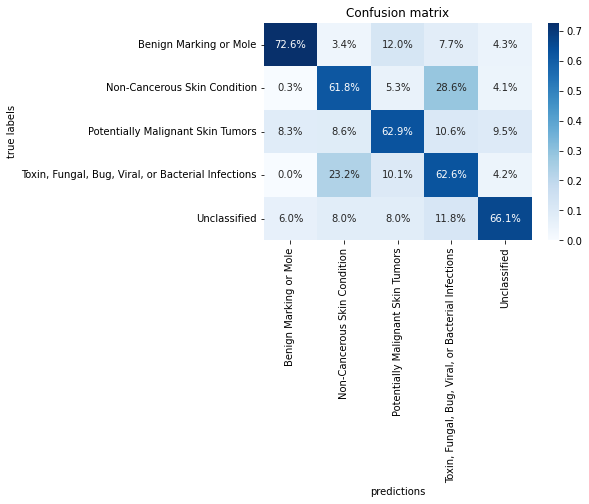

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015       NaN
37          5  0.0020       NaN
38          5  0.0025       NaN
39          5  0.0030       NaN
40          5  0.0035       NaN
41          5  0.0040       NaN
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS36
[epoch 1], [iter 100 of 211],[train loss 0.88196], [train acc 0.64938]
[epoch 1], [iter 200 of 211],[train loss 0.86618], [train acc 0.65961]
------------------------------------------------------------
[epoch 1], [val loss 0.90103], [val acc 0.64813]
----

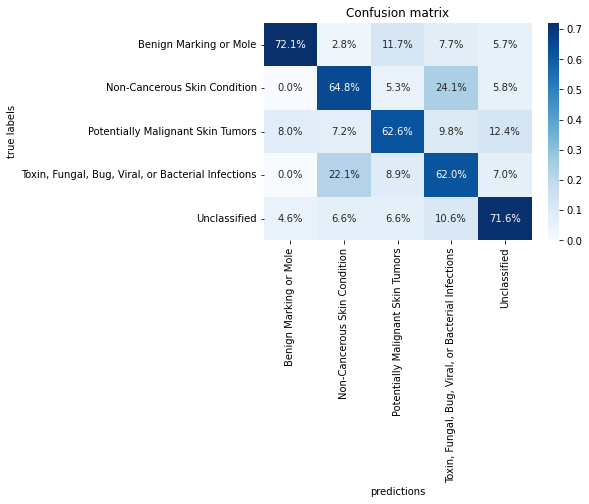

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020       NaN
38          5  0.0025       NaN
39          5  0.0030       NaN
40          5  0.0035       NaN
41          5  0.0040       NaN
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS37
[epoch 1], [iter 100 of 211],[train loss 0.77545], [train acc 0.69906]
[epoch 1], [iter 200 of 211],[train loss 0.78132], [train acc 0.69672]
------------------------------------------------------------
[epoch 1], [val loss 0.87622], [val acc 0.66243]
----

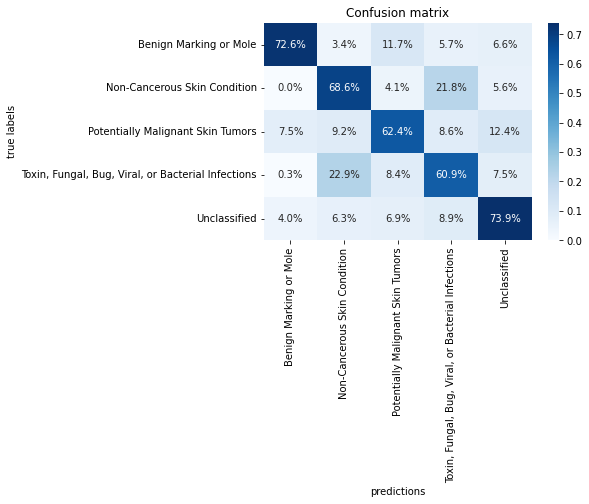

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025       NaN
39          5  0.0030       NaN
40          5  0.0035       NaN
41          5  0.0040       NaN
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS38
[epoch 1], [iter 100 of 211],[train loss 0.71358], [train acc 0.72250]
[epoch 1], [iter 200 of 211],[train loss 0.69119], [train acc 0.73531]
------------------------------------------------------------
[epoch 1], [val loss 0.86551], [val acc 0.67454]
----

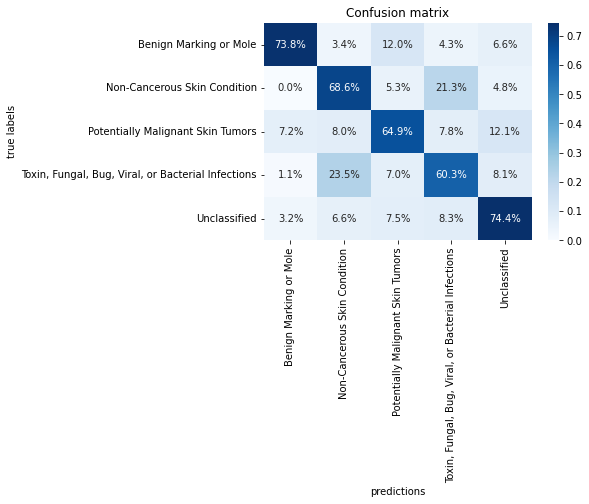

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030       NaN
40          5  0.0035       NaN
41          5  0.0040       NaN
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS39
[epoch 1], [iter 100 of 211],[train loss 0.57935], [train acc 0.79000]
[epoch 1], [iter 200 of 211],[train loss 0.58140], [train acc 0.78742]
------------------------------------------------------------
[epoch 1], [val loss 0.86965], [val acc 0.67733]
----

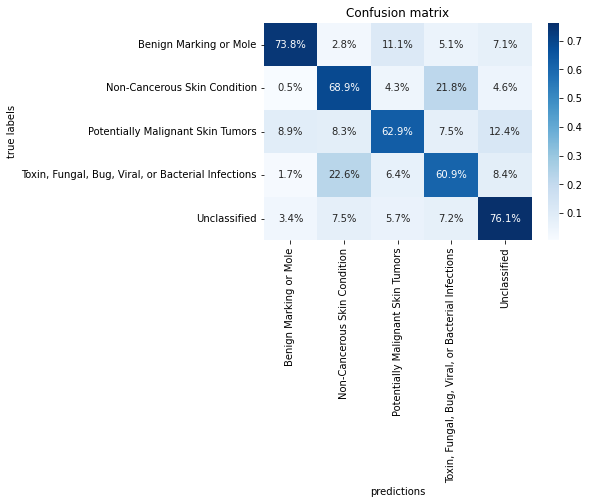

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035       NaN
41          5  0.0040       NaN
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS40
[epoch 1], [iter 100 of 211],[train loss 0.46312], [train acc 0.83953]
[epoch 1], [iter 200 of 211],[train loss 0.46443], [train acc 0.84023]
------------------------------------------------------------
[epoch 1], [val loss 0.88192], [val acc 0.68035]
----

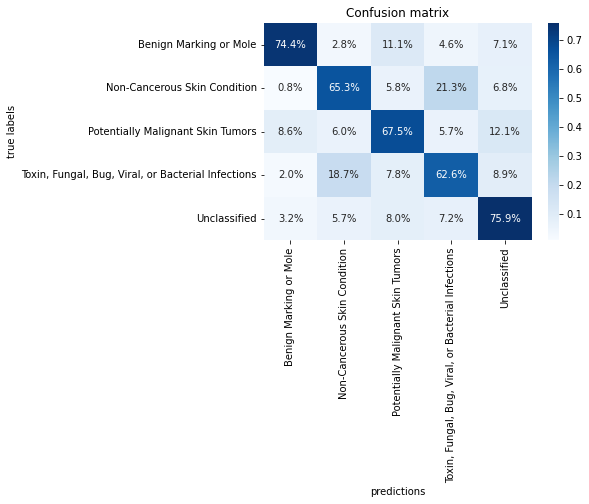

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040       NaN
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS41
[epoch 1], [iter 100 of 211],[train loss 0.32330], [train acc 0.89844]
[epoch 1], [iter 200 of 211],[train loss 0.32616], [train acc 0.89586]
------------------------------------------------------------
[epoch 1], [val loss 0.95804], [val acc 0.67587]
----

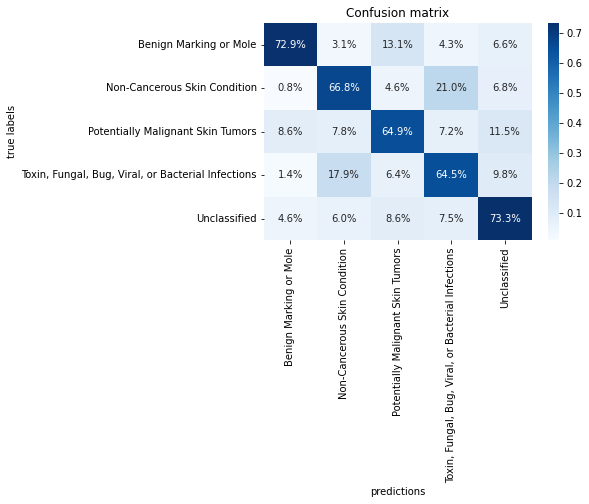

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010       NaN
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS42
[epoch 1], [iter 100 of 211],[train loss 0.39382], [train acc 0.85297]
[epoch 1], [iter 200 of 211],[train loss 0.38127], [train acc 0.86078]
------------------------------------------------------------
[epoch 1], [val loss 1.01493], [val acc 0.67393]
----

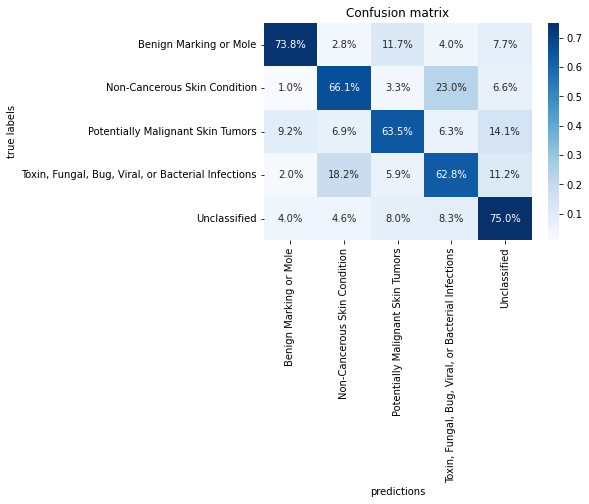

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015       NaN
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS43
[epoch 1], [iter 100 of 211],[train loss 0.14219], [train acc 0.96906]
[epoch 1], [iter 200 of 211],[train loss 0.14306], [train acc 0.96672]
------------------------------------------------------------
[epoch 1], [val loss 1.09260], [val acc 0.67878]
----

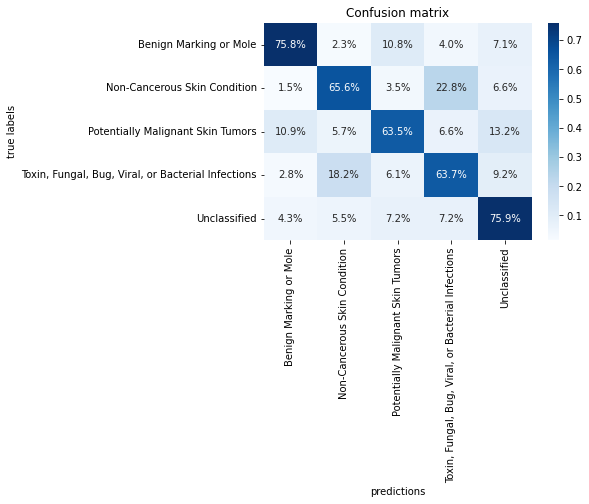

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020       NaN
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS44
[epoch 1], [iter 100 of 211],[train loss 0.06783], [train acc 0.98969]
[epoch 1], [iter 200 of 211],[train loss 0.06625], [train acc 0.98867]
------------------------------------------------------------
[epoch 1], [val loss 1.16870], [val acc 0.68181]
----

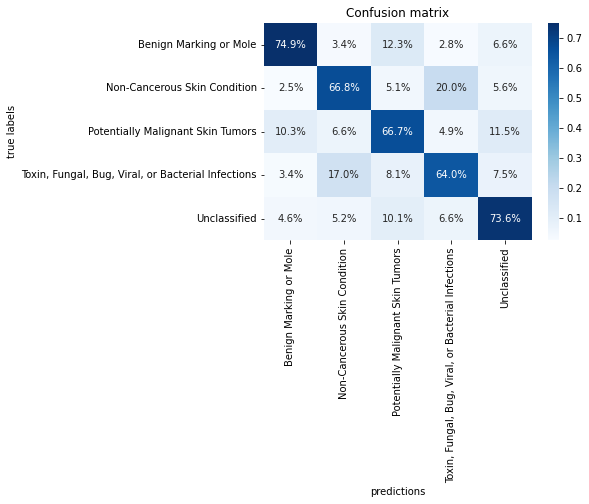

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025       NaN
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS45
[epoch 1], [iter 100 of 211],[train loss 0.03986], [train acc 0.99531]
[epoch 1], [iter 200 of 211],[train loss 0.03888], [train acc 0.99539]
------------------------------------------------------------
[epoch 1], [val loss 1.25814], [val acc 0.68072]
----

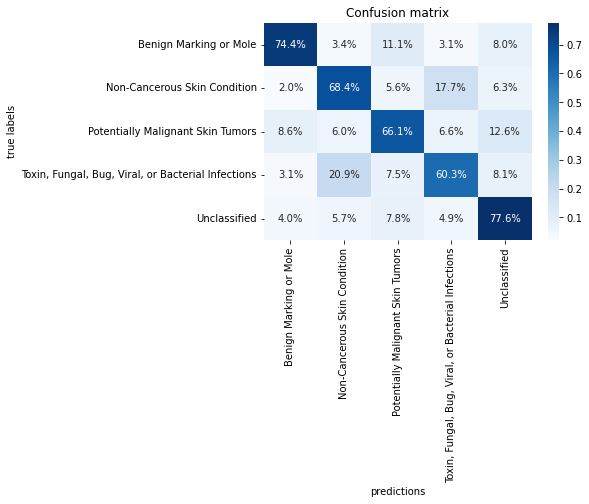

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025  0.692778
46          6  0.0030       NaN
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS46
[epoch 1], [iter 100 of 211],[train loss 0.02487], [train acc 0.99750]
[epoch 1], [iter 200 of 211],[train loss 0.02656], [train acc 0.99703]
------------------------------------------------------------
[epoch 1], [val loss 1.29774], [val acc 0.67890]
----

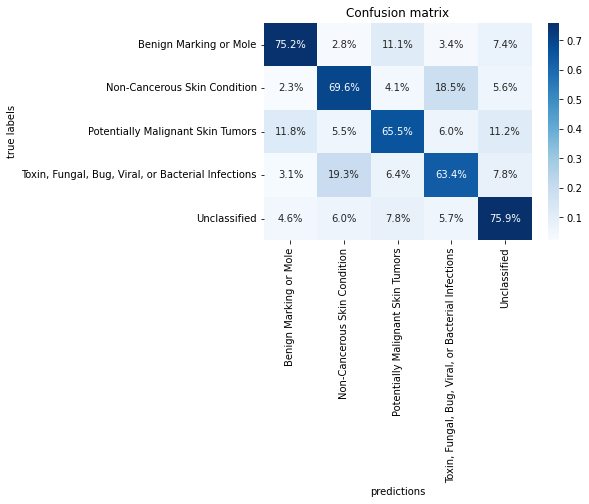

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025  0.692778
46          6  0.0030  0.698889
47          6  0.0035       NaN
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS47
[epoch 1], [iter 100 of 211],[train loss 0.01631], [train acc 0.99859]
[epoch 1], [iter 200 of 211],[train loss 0.01841], [train acc 0.99789]
------------------------------------------------------------
[epoch 1], [val loss 1.35016], [val acc 0.68726]
----

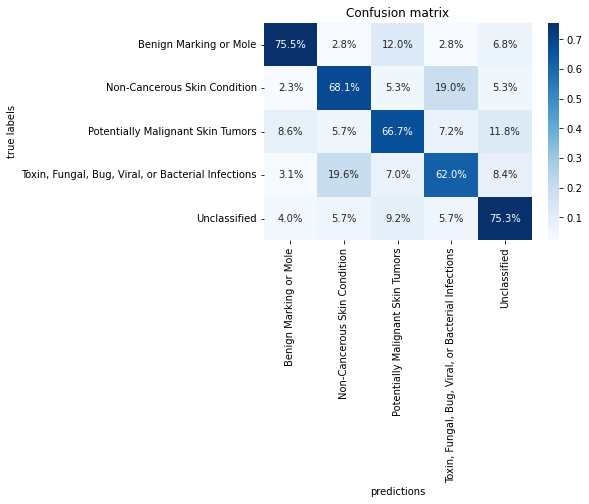

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025  0.692778
46          6  0.0030  0.698889
47          6  0.0035  0.694444
48          6  0.0040       NaN
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS48
[epoch 1], [iter 100 of 211],[train loss 0.01549], [train acc 0.99859]
[epoch 1], [iter 200 of 211],[train loss 0.01574], [train acc 0.99797]
------------------------------------------------------------
[epoch 1], [val loss 1.39216], [val acc 0.68689]
----

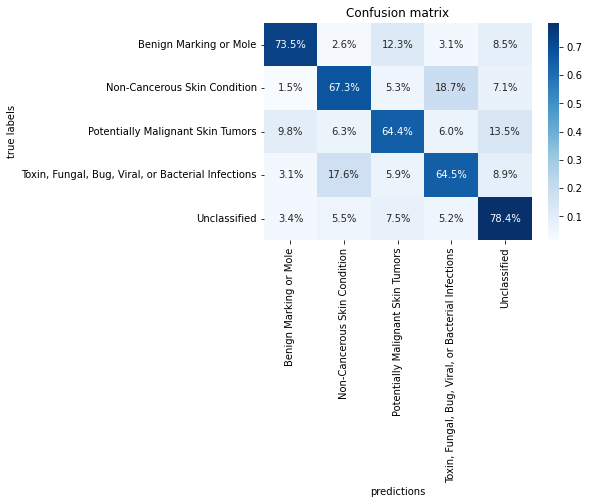

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025  0.692778
46          6  0.0030  0.698889
47          6  0.0035  0.694444
48          6  0.0040  0.695556
49          7  0.0010       NaN
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS49
[epoch 1], [iter 100 of 211],[train loss 0.48882], [train acc 0.84828]
[epoch 1], [iter 200 of 211],[train loss 0.44805], [train acc 0.85820]
------------------------------------------------------------
[epoch 1], [val loss 1.36396], [val acc 0.67745]
----

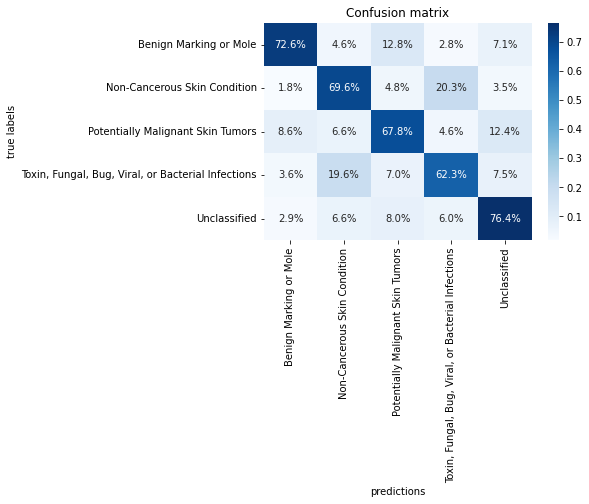

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025  0.692778
46          6  0.0030  0.698889
47          6  0.0035  0.694444
48          6  0.0040  0.695556
49          7  0.0010  0.697222
50          7  0.0015       NaN
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS50
[epoch 1], [iter 100 of 211],[train loss 0.12405], [train acc 0.96297]
[epoch 1], [iter 200 of 211],[train loss 0.13606], [train acc 0.95672]
------------------------------------------------------------
[epoch 1], [val loss 1.35826], [val acc 0.68072]
----

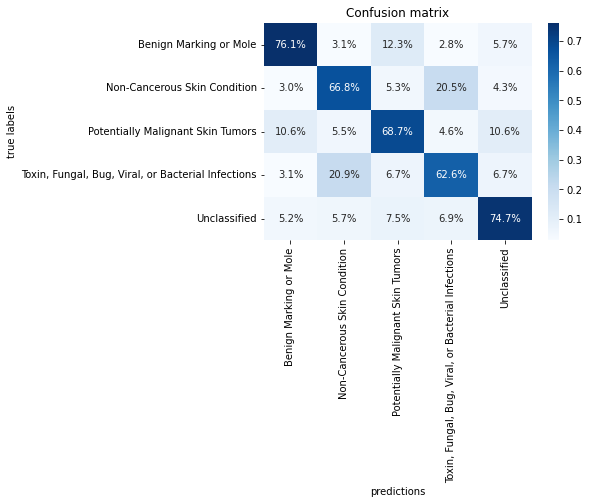

    transform      lr     accur
35          5  0.0010  0.651111
36          5  0.0015  0.665556
37          5  0.0020  0.676667
38          5  0.0025  0.683889
39          5  0.0030  0.685000
40          5  0.0035  0.690000
41          5  0.0040  0.684444
42          6  0.0010  0.681667
43          6  0.0015  0.687778
44          6  0.0020  0.691111
45          6  0.0025  0.692778
46          6  0.0030  0.698889
47          6  0.0035  0.694444
48          6  0.0040  0.695556
49          7  0.0010  0.697222
50          7  0.0015  0.696667
51          7  0.0020       NaN
52          7  0.0025       NaN
53          7  0.0030       NaN
54          7  0.0035       NaN
55          7  0.0040       NaN
Starting Training resnet_split3_3e_GS51
[epoch 1], [iter 100 of 211],[train loss 0.07024], [train acc 0.98266]
[epoch 1], [iter 200 of 211],[train loss 0.07214], [train acc 0.98102]
------------------------------------------------------------
[epoch 1], [val loss 1.37804], [val acc 0.68314]
----

In [ ]:
test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])

# Label dictionary for evaluation
labels_idx = np.sort(data.label_idx.unique())
label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map['label']))

for i in tdf.iterrows():
    t_num = int(i[1]['transform'])
    lr = i[1]['lr']
    
    model_dict['alias'] = i[0]
    model_dict['transform'] = t_num
    model_dict['lr'] = lr
    model_dict['tuned_model_name'] = f'resnet_split3_3e_GS{i[0]}'
    
    transform_list = transform_header + [transform_body[t_num]] + transform_footer
    train_transform = transforms.Compose(transform_list)
    train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])


    loaders = {'train_loader':train_loader,
                            'val_loader': val_loader,
                            'test_loader': test_loader}
    model_dict['loader'] = loaders

    train_model(model_dict = model_dict)
    
    pred_df = evaluate(model_name = f'gridsearch/resnet_split3_3e_GS{i[0]}', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)
    
    acc = len(pred_df[pred_df.lab_idx==pred_df.pred_idx])/len(pred_df)
    
    tdf.at[i[0], 'accur'] = acc
    
    direc = model_dict['mod_directory']
    nam = model_dict['tuned_model_name']
    pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')
    
    print(tdf.iloc[:i[0]][['transform', 'lr', 'accur']])

## Evaluate

In [ ]:
# # resnet_split3_3e
# pred_df = evaluate(model_name = 'resnet_split3_3e_2', 
#                    model_source = 'pt', 
#                    model_dict = model_dict, 
#                    label_dict = label_dict, 
#                    show_cm = False)